In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (9,6)

df = pd.read_csv('data/cpu_utilization_custom.csv')
df.head()


,timestamp,value
0,05-04-2024 00:00,0.132
1,05-04-2024 00:05,0.134
2,05-04-2024 00:10,0.134
3,05-04-2024 00:15,0.134
4,05-04-2024 00:20,0.134


In [48]:
anomalies_timestamp = [
        "18-04-2024 02:45",
        "17-04-2024 07:35"
    ]
df.head()

,timestamp,value
0,05-04-2024 00:00,0.132
1,05-04-2024 00:05,0.134
2,05-04-2024 00:10,0.134
3,05-04-2024 00:15,0.134
4,05-04-2024 00:20,0.134


In [50]:
df['is_anomaly'] = 1
for each in anomalies_timestamp:
    df.loc[df['timestamp'] == each, 'is_anomaly'] = -1
df.head()

,timestamp,value,is_anomaly
0,05-04-2024 00:00,0.132,1
1,05-04-2024 00:05,0.134,1
2,05-04-2024 00:10,0.134,1
3,05-04-2024 00:15,0.134,1
4,05-04-2024 00:20,0.134,1


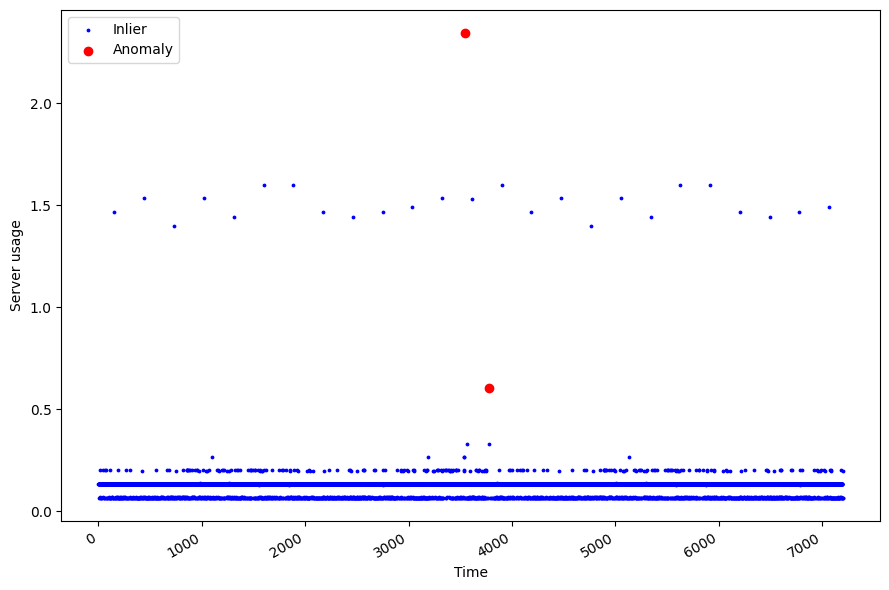

In [54]:
anomaly_df = df.loc[df['is_anomaly'] == -1]
inlier_df = df.loc[df['is_anomaly'] == 1]
fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df['value'], color='blue', s=3, label='Inlier')
ax.scatter(anomaly_df.index, anomaly_df['value'], color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('Server usage')
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()

Mean Absolute Deviation

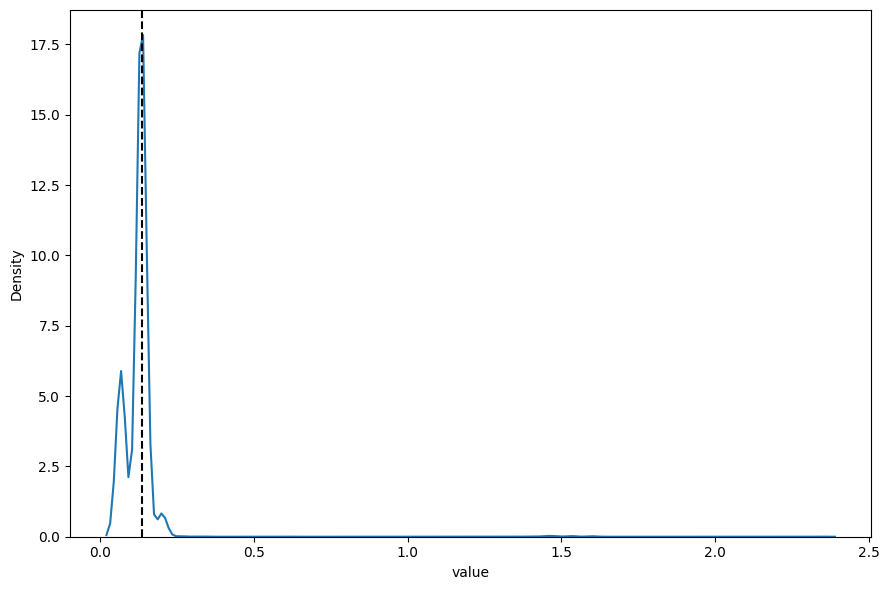

In [55]:
import seaborn as sns
sns.kdeplot(df['value'])
plt.grid(False)
plt.axvline(0.134,0,1,c='black',ls='--')
plt.tight_layout();

In [56]:
from scipy.stats import median_abs_deviation
mad=median_abs_deviation(df['value'])
median=np.median(df['value'])
print(mad,median)

def robust_zscore(x):
  return 0.6745*(x-median)/mad

0.0020000000000000018 0.134


mad~0

In [57]:
df['z-score']=df['value'].apply(robust_zscore)
df.head()

,timestamp,value,is_anomaly,z-score
0,05-04-2024 00:00,0.132,1,-0.6745
1,05-04-2024 00:05,0.134,1,0.0000
2,05-04-2024 00:10,0.134,1,0.0000
3,05-04-2024 00:15,0.134,1,0.0000
4,05-04-2024 00:20,0.134,1,0.0000


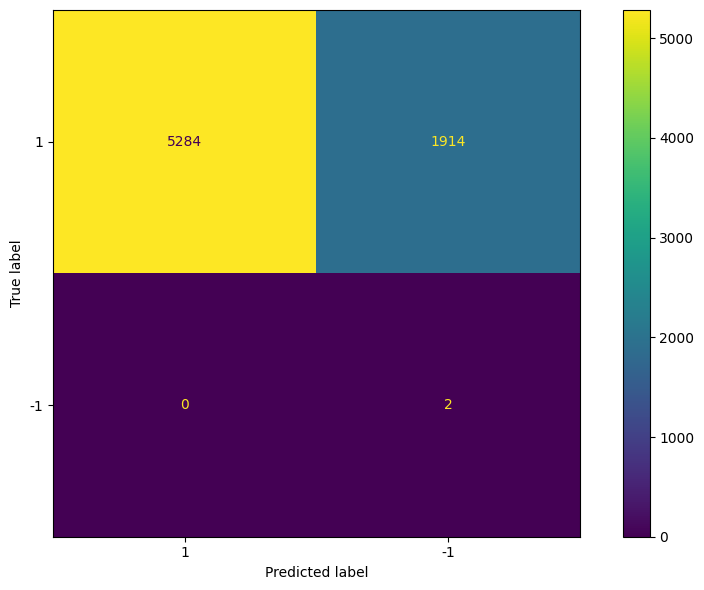

In [59]:
df['baseline']=1
df.loc[df['z-score']>=3.5, 'baseline']=-1
df.loc[df['z-score']<=-3.5, 'baseline']=-1

cm=confusion_matrix(df['is_anomaly'],df['baseline'], labels=[1,-1])
display_cm=ConfusionMatrixDisplay(cm,display_labels=[1,-1])
display_cm.plot();
plt.grid(False)
plt.tight_layout()

In [60]:
accuracy_score(df['is_anomaly'],df['baseline'])*100

73.41666666666666

Isolation Forest


In [61]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

train = df[:3550]
test = df[3550:]

contamination = 1/len(train)

i_forest= IsolationForest(contamination=contamination, random_state=42)
X_train=train['value'].values.reshape(-1,1)
i_forest.fit(X_train)

IsolationForest(contamination=0.00028169014084507044, random_state=42)

In [62]:
predictions=i_forest.predict(test['value'].values.reshape(-1,1))

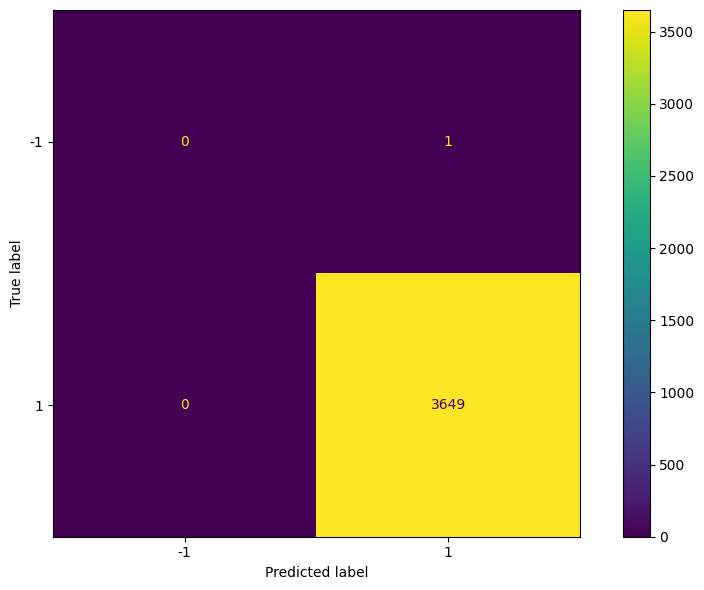

In [63]:
cm=confusion_matrix(test['is_anomaly'],predictions,labels=[-1,1])
display_cm= ConfusionMatrixDisplay(cm,display_labels=[-1,1])
display_cm.plot();
plt.grid(False)
plt.tight_layout()

In [64]:
from sklearn.metrics import accuracy_score
y_true=test['is_anomaly']
y_pred=predictions
accuracy_score(y_true,y_pred)*100

99.97260273972603

Local Outlier Factor

In [65]:
from sklearn.neighbors import LocalOutlierFactor
lof=LocalOutlierFactor(contamination=contamination,novelty=True)
lof.fit(X_train)


LocalOutlierFactor(contamination=0.00028169014084507044, novelty=True)

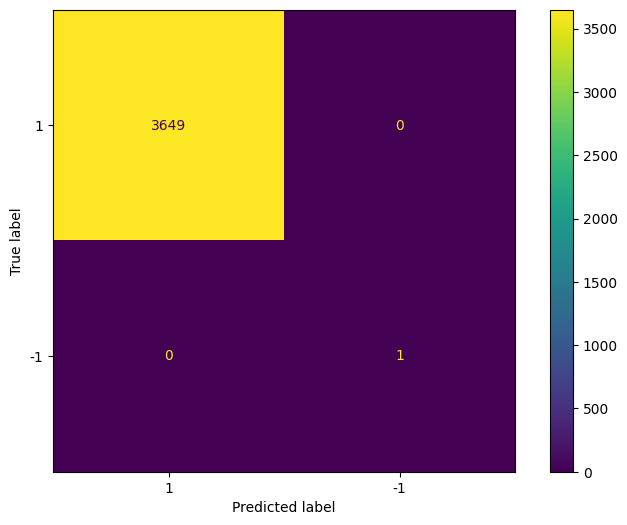

In [66]:
preds_lof=lof.predict(test['value'].values.reshape(-1,1))
cm=confusion_matrix(test['is_anomaly'],preds_lof,labels=[1,-1])
display_cm=ConfusionMatrixDisplay(cm,display_labels=[1,-1])
display_cm.plot();

In [67]:
accuracy_score(test['is_anomaly'],preds_lof)*100

100.0